The purpose of this notebook is to evaluate how many query vectors (nq) we need 
to get an accurate estimate of the intersection @ 10 measure. 


In [55]:
import numpy as np
import faiss
from faiss.contrib import datasets
from matplotlib import pyplot

In [69]:
# start with BigANN 10M

ds = datasets.DatasetBigANN(10)

In [5]:
# we need more query vectors than the usual 10k, so pick them from the training set

xtt = ds.get_train(maxtrain=2 * 10**6)

big_xq = xtt[:10**6]  # 1M queries 
xt = xtt[10**6:]      # 1M training vectors

# Ground truth

In [18]:
index = faiss.IndexFlatL2(128)
index.add(ds.get_database())

In [19]:
index = faiss.index_cpu_to_all_gpus(index, ngpu=1)

In [20]:
%%time
Dgt, Igt = index.search(big_xq, 10)

CPU times: user 4min 59s, sys: 2min 8s, total: 7min 8s
Wall time: 7min 8s


In [21]:
np.save("/tmp/Dgt.npy", Dgt)
np.save("/tmp/Igt.npy", Igt)

# With some index

In [27]:
# we pick some index that has one search-time parameter 
# to represent different speed-accuracy tradeoffs.

index = faiss.index_factory(128, "IVF16384,SQ4")
index = faiss.index_cpu_to_all_gpus(index, ngpu=1)

index.train(xt)

index.add(ds.get_database())

In [48]:
# run queries 

res_per_nprobe = {}
for nprobe in 1, 4, 16, 64:
    print(nprobe)
    D, I = [], []
    index.nprobe = nprobe
    # Faiss crashes when searching all at once
    for i0 in range(0, 10**6, 10000): 
        Di, Ii = index.search(big_xq[i0 : i0 + 10000], 10)
        D.append(Di)
        I.append(Ii)
    D = np.vstack(D)
    I = np.vstack(I)
    res_per_nprobe[nprobe] = I

1
4
16
64


# Stats on intersection measure

In [70]:
# evaluate intersection measures for the 1M queries

for nprobe in 1, 4, 16, 64: 
    I = res_per_nprobe[nprobe]
    ninter = faiss.eval_intersection(I, Igt)
    print(f"nprobe {nprobe:-5d} inter {100 * ninter/I.size:.3f} %")

nprobe     1 inter 25.914 %
nprobe     4 inter 49.756 %
nprobe    16 inter 68.647 %
nprobe    64 inter 77.002 %


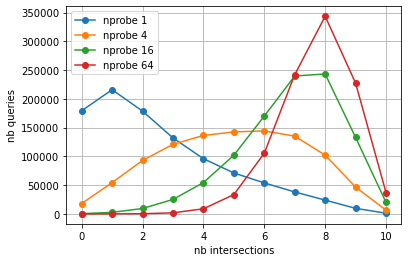

In [60]:
# collect per-query intersections

all_ninters = {}
for nprobe in 1, 4, 16, 64: 
    I = res_per_nprobe[nprobe]    
    ninters = [
        faiss.eval_intersection(I[i0 : i0 + 1], Igt[i0 : i0 + 1])
        for i0 in range(10**6)
    ]
    all_ninters[nprobe] = ninters
    pyplot.plot(np.bincount(ninters), 'o-', label=f"nprobe {nprobe}")
pyplot.xlabel("nb intersections")
pyplot.ylabel("nb queries")
pyplot.legend()
pyplot.grid()    


In [68]:
# do some math to compute standard deviations

for nprobe in 1, 4, 16, 64: 
    intersection_measures = np.array(all_ninters[nprobe]) / 10 
    variance = intersection_measures.var()
    print("nprobe", nprobe)
    for n in 10**3, 10**4, 10**5, 10**6: 
        # sum of independent variables
        # https://en.wikipedia.org/wiki/Variance#Sum_of_uncorrelated_variables_.28Bienaym.C3.A9_formula.29
        variance_of_sum = n * variance
        variance_of_mean = variance_of_sum * (1 / n) ** 2
        sttdev_of_mean = np.sqrt(variance_of_mean)
        print(f"n={n:-7} stddev {100*sttdev_of_mean:.3f} % (percentage points)")

nprobe 1
n=   1000 stddev 0.705 %
n=  10000 stddev 0.223 %
n= 100000 stddev 0.071 %
n=1000000 stddev 0.022 %
nprobe 4
n=   1000 stddev 0.727 %
n=  10000 stddev 0.230 %
n= 100000 stddev 0.073 %
n=1000000 stddev 0.023 %
nprobe 16
n=   1000 stddev 0.525 %
n=  10000 stddev 0.166 %
n= 100000 stddev 0.053 %
n=1000000 stddev 0.017 %
nprobe 64
n=   1000 stddev 0.382 %
n=  10000 stddev 0.121 %
n= 100000 stddev 0.038 %
n=1000000 stddev 0.012 %
